In [26]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from concurrent.futures import ThreadPoolExecutor

# from utils.methods_RLRW import (
#     runif_ball, 
#     euclid_distance, 
#     weighted_quantile, 
#     smoothed_weighted_quantile, 
#     opt_RLCP_h, 
#     RLCP
# )

from utils.plot_utils import regression_plot_with_uncertainty
from utils.Prediction_bands import (
    split_conformal_bands,
    weighted_split_conformal_prediction
)

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)


from scipy.stats import multivariate_normal, norm

In [27]:
from utils.methods_RLRW import (
    runif_ball, 
    euclid_distance, 
    weighted_quantile, 
    smoothed_weighted_quantile, 
    opt_RLCP_h, 
    RLCP
)

In [28]:
path = "../Data/electricity-normalized.csv"
data = pd.read_csv(path)

In [29]:
data

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.0000,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,UP
1,0.0000,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,UP
2,0.0000,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,UP
3,0.0000,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,UP
4,0.0000,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,DOWN
...,...,...,...,...,...,...,...,...,...
45307,0.9158,7,0.914894,0.044224,0.340672,0.003033,0.255049,0.405263,DOWN
45308,0.9158,7,0.936170,0.044884,0.355549,0.003072,0.241326,0.420614,DOWN
45309,0.9158,7,0.957447,0.043593,0.340970,0.002983,0.247799,0.362281,DOWN
45310,0.9158,7,0.978723,0.066651,0.329366,0.004630,0.345417,0.206579,UP


In [30]:
import time
from concurrent.futures import ThreadPoolExecutor
def run(X_, Y_, alpha, prediction_interval, methods, indexing = None):

    rho = rho_LS = 0.99 
    X = X_
    Y = Y_
    N = X.shape[0]
    train_lag = 100
    PI_split_CP = prediction_interval
    
    
    def predict(pred_idx):
        time.sleep(0.1)

        # we predict the point at pred_idx (n+1) starting at pred_idx=train_lag (101-th datapoint)

        for method_idx, method in enumerate(methods):
            # calibration weights for non-exchangeable conformal prediction (nexCP)
            if method in ['nexCP+LS', 'nexCP+WLS']:
                # weights at 1, ..., n (notice: in Python arrays this becomes 0, ..., n-1)
                weights = rho**(np.arange(pred_idx,0,-1))
                # weight n+1 should always be 1
                weights = np.r_[weights,1]
            else:
                weights = np.ones(pred_idx+1)
            
            # weights for weighted linear regression (WLS)
            if method == 'nexCP+WLS':
                # tags 1, ..., n+1
                tags = rho_LS**(np.arange(pred_idx,-1,-1))
            else:
                tags = np.ones(pred_idx+1)
                

            if indexing == "odd":
                inds_odd = np.arange(1,int(np.ceil(pred_idx/2)*2-1),2) # excludes pred_idx
                inds_even = np.arange(2,int(np.floor(pred_idx/2)*2),2) # excludes pred_idx

            

                # train a weighted least squares regression (tags are the weights)
                predictor = LinearRegression()
                predictor.fit(X[inds_odd], Y[inds_odd], tags[inds_odd])

                mean_prediction, prediction_bands, quantile = weighted_split_conformal_prediction(
                    predictor, # the trained weighted linear regression model
                    X[inds_even], # calibration inputs
                    Y[inds_even], # calibration targets
                    X[pred_idx][np.newaxis, :], # test point to predict
                    weights[inds_odd], # calibration score weights
                    alpha     # target miscoverage rate
                )
                PI_split_CP[method_idx,pred_idx,:] = prediction_bands
                        
            
            else: 
                inds_all = np.arange(pred_idx)  # Use all indices up to pred_idx

                predictor = LinearRegression()
                predictor.fit(X[inds_all], Y[inds_all], sample_weight=tags[inds_all])

                mean_prediction, prediction_bands, quantile = weighted_split_conformal_prediction(
                    predictor,
                    X[inds_all],  # Calibration inputs
                    Y[inds_all],  # Calibration targets
                    X[pred_idx][np.newaxis, :],  # Test point to predict
                    weights[inds_all],  # Calibration score weights
                    alpha  # Target miscoverage rate
                )
                PI_split_CP[method_idx, pred_idx, :] = prediction_bands
                
            

    with ThreadPoolExecutor() as executor:
        list(tqdm(executor.map(predict, np.arange(train_lag, N)), total = N-train_lag))
        
    return PI_split_CP
        


In [31]:
def run_rlrw(X_, Y_, alpha, prediction_interval, method, h, indexing = None): 
    X = X_
    Y = Y_
    N = X.shape[0]
    train_lag = 100
    PI_split_CP = prediction_interval
    
    
    def predict(pred_idx):
        
        if method == "gaussian":
            X_tilde = multivariate_normal.rvs(mean = X[pred_idx], cov = np.diag(np.ones(X.shape[1])*h**2))
            
            weights = 1/((2 * np.pi * h**2)**(X.shape[1]/2)) * np.exp(-0.5 * np.sum((X[:pred_idx] - X_tilde)**2, axis = 1)/h**2)
            
            
        if method == "box":
            X_tilde = runif_ball(X[pred_idx], h)
            
            weights = np.prod(np.abs(X[:pred_idx] - X_tilde) < h, axis = 1)
            
        tags = weights[:-1]
            
        if indexing == "odd":
            
            inds_odd = np.arange(1,int(np.ceil(pred_idx/2)*2-1),2) # excludes pred_idx
            inds_even = np.arange(2,int(np.floor(pred_idx/2)*2),2) # excludes pred_idx

        

            # train a weighted least squares regression (tags are the weights)
            predictor = LinearRegression()
            predictor.fit(X[inds_odd], Y[inds_odd], tags[inds_odd])

            mean_prediction, prediction_bands, quantile = weighted_split_conformal_prediction(
                predictor, # the trained weighted linear regression model
                X[inds_even], # calibration inputs
                Y[inds_even], # calibration targets
                X[pred_idx][np.newaxis, :], # test point to predict
                weights[inds_odd], # calibration score weights
                alpha     # target miscoverage rate
            )
            PI_split_CP[pred_idx,:] = prediction_bands
            
            
                    
                

    with ThreadPoolExecutor() as executor:
        list(tqdm(executor.map(predict, np.arange(train_lag, N)), total = N-train_lag))
        
    return PI_split_CP

In [46]:
"""
    GENERATING \Tilde{X} FOR BOX KERNEL
"""

def runif_ball(n, center, radius):
    d = len(center)
    U = np.random.rand(n)
    Z = np.random.normal(size=(n, d))
    norms = np.linalg.norm(Z, axis=1)
    data = center + radius * (U ** (1 / d))[:, np.newaxis] * Z / norms[:, np.newaxis]
    return data
    

"""
    LOCALISATION KERNEL FOR BOX KERNEL
"""
def euclid_distance(x,y):
    return np.linalg.norm(x-y)


@staticmethod
def weighted_quantile(x, q, w):
    weights = w/np.sum(w)
    sorted_indices = np.argsort(x)
    cum_sum = np.cumsum(weights[sorted_indices])
    quantile = np.interp(q, cum_sum, x[sorted_indices])
    return 


"""
    Computing Smoothed Weighted Quantile
"""
def smoothed_weighted_quantile(v, alpha, w, indices):
    """
    input:
        v: Unique scores
        alpha: smoothing parameter
        w: weights
        indices: indices of the scores
    output: 
        smoothed_weighted_quantile: smoothed weighted quantile
    """
    weight = w / np.sum(w)
    U = np.random.rand()
    v_tilde = v
    w_tilde = np.zeros(len(v_tilde))
    for i in range(len(v_tilde)):
        w_tilde[i] = np.sum(w[indices[i]])
        
    p_values = np.zeros(len(v_tilde))
    for i in range(len(v_tilde) - 1):
        p_values[i] = np.sum(w_tilde[1: len(v_tilde) - i]) + U * w_tilde[-1]
        
    p_values[-1] = U * w_tilde[-1]

    if np.sum(p_values[p_values > alpha]) > 0: 
        id = np.max(np.where(p_values > alpha))
        quantile = v_tilde[id]
        
        if id < len(v_tilde) - 1:
            subarray_sum = np.sum(w_tilde[(id + 1):(len(v_tilde) - 1)])
            closed = (subarray_sum + U * (w_tilde[id] + w_tilde[-1]) > alpha)
        elif id == len(v_tilde):
            closed = False
        elif id == len(v_tilde) - 1:
            closed = (U * (w_tilde[id] + w_tilde[-1]) > alpha)
    else:
        quantile = float('-inf')
        closed = False
    return quantile, closed



def weighted_conformal_prediction(predictor,
                                        X_cal,
                                        y_cal,
                                        X_test,
                                        cal_weights,
                                        alpha=0.95
                                        ):
    """ 
    Weighted Split Conformal Prediction (taken from github.io/code/nonexchangeable_conformal.zip) 
    """

    # normalize weights (we add +1 in the denominator for the test point at n+1)
    

    weights_normalized = cal_weights / (np.sum(cal_weights) + 1)

    if(np.sum(weights_normalized) >= 1-alpha):
        # calibration scores: |y_i - x_i @ betahat|
        R = np.abs(y_cal - predictor.predict(X_cal))
        ord_R = np.argsort(R)
        # from when are the cumulative quantiles at least 1-\alpha
        ind_thresh = np.min(np.where(np.cumsum(weights_normalized[ord_R])>=1-alpha)) if not None else len(weights_normalized)
        # get the corresponding residual
        quantile = np.sort(R)[ind_thresh]
        
    else:
        quantile = 1
    
    # Standard prediction intervals using the absolute residual score quantile
    mean_prediction = predictor.predict(X_test)
    prediction_bands = np.stack([
        mean_prediction - quantile,
        mean_prediction + quantile
    ], axis=1)
    
    return mean_prediction, prediction_bands, quantile

    

"""
    OPTIMUM BANDWIDTH FOR RLCP
"""

def opt_RLCP_h(X_train, kernel, h_min, eff_size):
    n_train, d = X_train.shape
    
    def effsize(h):
        H = np.zeros((n_train, n_train))
        for i in range(n_train):
            if kernel == "gaussian":
                xtilde_train = np.random.multivariate_normal(mean=X_train[i, :], cov=np.eye(d) * h**2, size=1)
                H[i, :] = multivariate_normal.pdf(X_train, mean=xtilde_train.flatten(), cov=np.eye(d) * h**2)
                
            elif kernel == "box":
                x_tilde_trains = runif_ball(n_train, X_train[i, :], h)
                H[i, :] = np.apply_along_axis(lambda x: np.prod(np.abs(x - X_train[i, :]) <= h), 1, x_tilde_trains)
                
            H[i,:] = H[i,:] / np.sum(H[i,:])
        effective_size = n_train/np.linalg.norm(H, ord = "fro")**2 - 1
        return effective_size

    
    candidate_bandwidths = np.arange(h_min, 6.02, 0.02)
    
    i, optimiser = 1, 0
    while optimiser < eff_size or i > len(candidate_bandwidths):
        optimiser  = effsize(candidate_bandwidths[i])
        h_opt = candidate_bandwidths[i]
        i += 1
    
    return h_opt

    
"""
    Locally weighted CP methods
"""
def RLCP(Xcalib, scores_calib, X_test, scores_test, kernel, h, alpha):
    n_test, d = X_test.shape
    coverage = [0] * n_test
    score_threshold = [0] * n_test
    
    # Sorting with respect to the order of calibration scores
    Xcalib = Xcalib[np.argsort(scores_calib), :]
    scores_calib = np.sort(scores_calib)
    
    # Finding unique scores and the indices where each of these unique scores have been repeated
    scores = np.append(scores_calib, np.inf)
    indices = []
    j = 0
    i = 0
    scores_unique = []
    
    while i < len(scores):
        current_score = scores[i]
        scores_unique.append(current_score)
        current_indices = np.where(scores == current_score)[0]
        indices.append(current_indices)
        i += len(current_indices)
        j += 1
    
    for i in tqdm(range(n_test)):
        xtest = X_test[i]
        test_score = scores_test[i]
        cov_data = np.vstack([Xcalib, xtest])
        
        # Finding the weights and the score threshold
        if kernel == "gaussian":
            xtilde_test = multivariate_normal.rvs(mean=xtest, cov=np.diag(np.ones(d)) * h**2)
            weights = multivariate_normal.pdf(cov_data, mean=xtilde_test, cov=np.diag(np.ones(d)) * h**2)
            result = smoothed_weighted_quantile(scores_unique, alpha, weights, indices)
        elif kernel == "box":
            xtilde_test = runif_ball(1, xtest, h).flatten()
            weights = np.array([1 if euclid_distance(x, xtilde_test) <= h else 0 for x in cov_data])
            result = smoothed_weighted_quantile(scores_unique, alpha, weights, indices)
        
        score_threshold[i] = result[0]  # score_threshold
        closed = result[1]   # whether it's a closed interval
        
        # Coverage
        coverage[i] = int(test_score < score_threshold[i])
        if closed:
            coverage[i] = int(test_score <= score_threshold[i])
    
    return np.column_stack((coverage, score_threshold))

In [35]:

def simulation(n, d, setting):
    X = np.random.multivariate_normal(mean=np.zeros(d), cov=np.eye(d), size=n)
    
    if setting == 1:
        Y = 0.5 * np.mean(X, axis=1) + np.sum(np.abs(np.sin(X)), axis=1) * np.random.normal(0, 1, n)
    elif setting == 2:
        Y = 0.5 * np.mean(X, axis=1) + np.sum(2 * norm.pdf(X, 0, 1.5), axis=1) * np.random.normal(0, 1, n)
    
    data = np.column_stack((Y, X))
    
    return data

def conditional_simulation(n=100, setting=1):
    X = np.arange(-3, 3.01, 0.01).reshape(-1, 1)
    N = np.random.normal(0, 1, len(X))
    
    if setting == 1:
        Y = 0.5 * np.mean(X, axis=1) + np.abs(np.sin(X)).flatten() * N
    elif setting == 2:
        Y = 0.5 * np.mean(X, axis=1) + 2 * norm.pdf(X, 0, 1.5).flatten() * N
    
    data = pd.DataFrame(np.column_stack((Y, X)), columns=['Y'] + [f'X{i+1}' for i in range(X.shape[1])])
    return data



In [34]:
dseq = [1] + [5 * i for i in range(1, 11)]
n = 2000
eff_size = 50

optimum_RLCP_bandwidth = np.zeros(len(dseq))
optimum_calLCP_bandwidth = np.zeros(len(dseq))

for i in tqdm(range(len(dseq))):
    if i == 0:
        h_min_RLCP = h_min_calLCP = 0.02
    else:
        h_min_RLCP = optimum_RLCP_bandwidth[i - 1]
        h_min_calLCP = optimum_calLCP_bandwidth[i - 1]
    start =  time.time()
    Xtrain = simulation(n, dseq[i], 1)[:, 1:]  # Assuming the simulation function returns a numpy array
    optimum_RLCP_bandwidth[i] = opt_RLCP_h(Xtrain, "gaussian", h_min_RLCP, eff_size)
    end = time.time()
    print(f"Time taken for d = {dseq[i]}: {end - start}") 
    
print(optimum_RLCP_bandwidth)

  9%|▉         | 1/11 [00:00<00:04,  2.47it/s]

Time taken for d = 1: 0.40391087532043457


  9%|▉         | 1/11 [00:05<00:55,  5.53s/it]


KeyboardInterrupt: 

In [36]:
data = simulation(2000, 1, 1)
X = data[:, 1:]
Y = data[:, 0]
h = 1.5
alpha = 0.1
weight = "gaussian"
PI_split_CP = np.zeros((len(Y), 2))
train_lag = 100

PI_split_CP[:train_lag, 0] = -np.inf
PI_split_CP[:train_lag, 1] = np.inf


In [37]:
PI_split_CP = run_rlrw(X, Y, alpha, PI_split_CP, weight, h)

100%|██████████| 1900/1900 [00:00<00:00, 6300.97it/s]


In [38]:
N = len(Y)
coverage = np.zeros(N-train_lag)
pi_width = np.zeros(N-train_lag)


lower_bound = PI_split_CP[100:, 0]  
upper_bound = PI_split_CP[100:, 1]

coverage =(lower_bound <= Y[100:]) & (upper_bound >= Y[100:])
pi_width = upper_bound - lower_bound

In [39]:
import pandas as pd
coverage_series = pd.Series(coverage)
coverage_counts = coverage_series.value_counts()
coverage_counts


False    1900
Name: count, dtype: int64

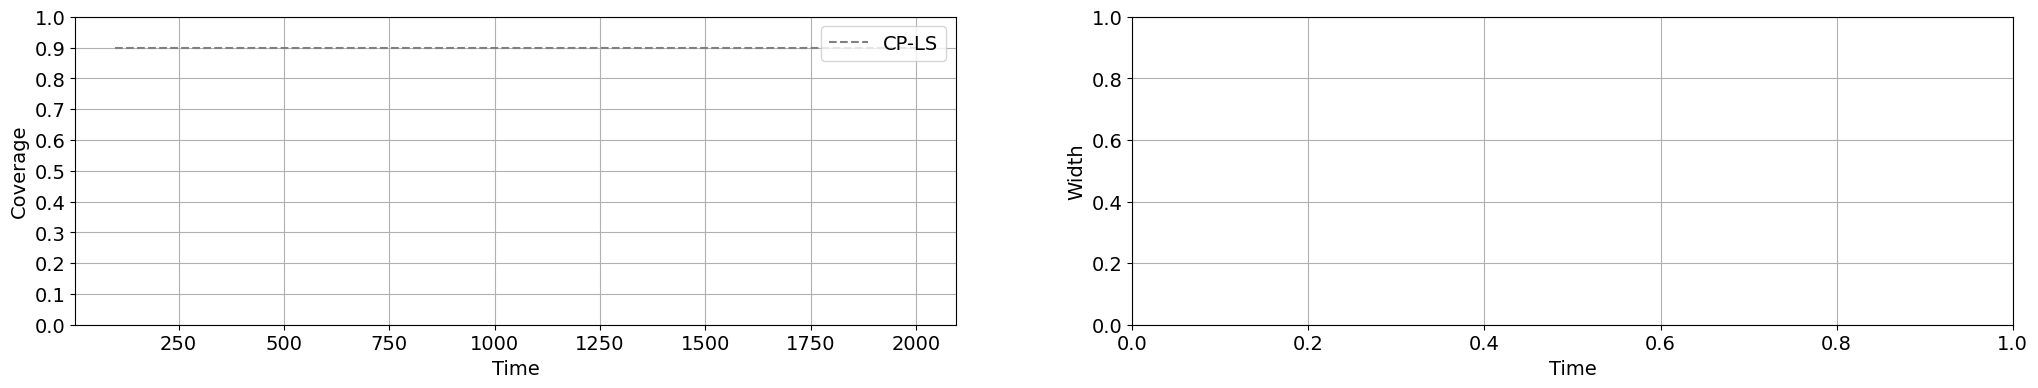

In [40]:
plt.rcParams.update({'font.size': 14})

window = 300 # will display a rolling average

def rolling_avg(x,window):
    return np.convolve(x, np.ones(window)/window)[(window-1):-window]
    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,4))


ax[0].hlines(1-alpha, xmin=train_lag, xmax=N, linestyles='--', colors='gray')
ax[0].legend(['CP-LS','nexCP+LS','nexCP+WLS'])

ax[0].set_ylabel('Coverage')
ax[0].set_ylim([0, 1])
ax[0].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax[0].set_xlabel('Time')
ax[0].grid(True)

ax[1].set_ylabel('Width')
ax[1].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax[1].set_xlabel('Time')
ax[1].grid(True)

plt.show()

In [49]:
# Parameters
ntrain = 100  
ncalib = 50   
ntest = 50    
d = 10        
setting = 1  # replace with your setting

# Training data
train_data = simulation(ntrain, d, setting)
X_train = train_data[:, 1:]
y_train = train_data[:,1]

# Create and train the linear regression model
model_lm = LinearRegression()
model_lm.fit(X_train, y_train)

# Calibration data
calib_data = simulation(ncalib, d, setting)
X_calib = calib_data[:, 1:]
y_calib = calib_data[:, 1]
scores_calib = np.abs(y_calib - model_lm.predict(X_calib))

# Test data
test_data = simulation(ntest, d, setting)
X_test = test_data[:,1:]
y_test = test_data[:,1]
scores_test = np.abs(y_test - model_lm.predict(X_test))

# If you need to convert scores to a DataFrame
scores_calib_df = pd.DataFrame(scores_calib, columns=['Calibration_Scores'])
scores_test_df = pd.DataFrame(scores_test, columns=['Test_Scores'])

In [42]:
help(RLCP)

Help on function RLCP in module __main__:

RLCP(Xcalib, scores_calib, X_test, scores_test, kernel, h, alpha)



In [50]:
RLCP(X_calib, scores_calib, X_test, scores_test, "gaussian", 2.64, 0.1)

100%|██████████| 50/50 [00:00<00:00, 3510.76it/s]


array([[  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0., -inf],
       [  0.,

In [ ]:
col_names = data.columns
data = data.to_numpy()

# remove the first stretch of time where 'transfer' does not vary
data = data[17760:]

# set up variables for the task (predicting 'transfer')
covariate_col = ['nswprice', 'nswdemand', 'vicprice', 'vicdemand']
response_col = 'transfer'
# keep data points for 9:00am - 12:00pm
keep_rows = np.where((data[:,2]>data[17,2])&(data[:,2]<data[24,2]))[0]

X = data[keep_rows][:,np.where([t in covariate_col for t in col_names])[0]]
Y = data[keep_rows][:,np.where(col_names==response_col)[0]].flatten()
X = X.astype('float64')
Y = Y.astype('float64')

N = X.shape[0]; p = X.shape[1]; alpha = 0.1
train_lag = 100 # start predicting after train_lag many observations

# randomly permuted data 
perm = np.random.choice(N,N,replace=False)
X_perm = X[perm]
Y_perm = Y[perm]

rho = rho_LS = 0.99


alpha = 0.1
methods = ['CP+LS', 'nexCP+LS', 'nexCP+WLS']
PI_split_CP = np.zeros((len(methods),N,2))
PI_split_CP[:, :train_lag, 0] = -np.inf
PI_split_CP[:, :train_lag, 1] = np.inf


In [ ]:
len(X)

3444

In [ ]:
print("--"*30)
print('Running conformal prediction on non-permuted data')
PI_split_CP = run(X, Y, alpha, PI_split_CP, methods, indexing = "odd")
print("--"*30)
print('Running conformal prediction on permuted data')
# PI_split_CP_perm = run(X_perm, Y_perm, alpha, PI_split_CP, methods, "odd")

------------------------------------------------------------
Running conformal prediction on non-permuted data


100%|██████████| 3344/3344 [00:30<00:00, 108.57it/s]

------------------------------------------------------------
Running conformal prediction on permuted data


In [ ]:
arr = [i for i in range(9)]
arr[:-1]

[0, 1, 2, 3, 4, 5, 6, 7]